In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from tqdm import tqdm  # Import tqdm for progress visualization


import numpy as np

In [151]:
class Box():
    """Box-class: defining a rectangular box-shape, in which Particles can roam. One corner is always (0,0)\n
    box         : 2-dimensional array of the two lengths of the x- and y-axis, corresponding to the boundaries of the box.\n
    particles   : a list of all particles in the box\n
    n_particles : the number of particles inside of the box
    """
    def __init__(self, box_size, n_Particles:int, boundary:bool, rng_seed:int|None=None):
        """Initializing the Box-class\n
        box_size    : a 2-dimensional array of the two lengths of the x- and y-axis, corresponding to the boundaries of the box.\n
        n_Particles : an integer of the number of Particles in the box. Needed to initialize all arrays correctly.\n
        boundary    : Wether the box_borders are hard boundaries.\n
        rng_seed    : Random Number Generator seed for reproducible results. None for random seed.
        """
        # constants
        self.c_6        = 6.2647225     # kg/mol  *  nm**8/ns**2
        self.c_12       = 9.847044e-3   # kg/mol  *  nm**14/ns**2
        self.kB         = 1.380e-23     # J/K
        self.avogadro   = 6.022e23      # 1/mol

        self.box_size       = box_size
        # Particles statistics are no longer stored in a separate class but in arrays, which allows for easier calculations
        self.particles_pos  = np.zeros((n_Particles,2), dtype=float) # shape (n,2)
        self.particles_vel  = np.zeros((n_Particles,2), dtype=float) # shape (n,2)
        self.particles_acc  = np.zeros((n_Particles,2), dtype=float) # shape (n,2)

        # All of the radii stored in an array
        # Additionally the combined raddii are calculated for each pair
        self.particles_r    = np.zeros(n_Particles, dtype=float)
        self.combined_radii = self.particles_r[:,np.newaxis] + self.particles_r[np.newaxis,:] # shape (n,n)

        # All of the masses are stored in an array
        self.particles_m    = np.zeros(n_Particles, dtype=float)
        
        # We use distance matrices for true distances (distances_mat) in x and y coords, 
        # distances with ghost particles for cross boundary calculations (distance_ghost) in x and y coords
        # and the norm of the ghost_distances as a single float
        if not boundary:
            self.distance_ghost     = np.zeros((n_Particles,n_Particles,2), dtype=float)
            self.distance_abs_ghost = np.zeros((n_Particles,n_Particles), dtype=float)
        self.distance_mat       = np.zeros((n_Particles,n_Particles,2), dtype=float)
        self.distance_abs       = np.zeros((n_Particles,n_Particles), dtype=float)
        # A vectorial force matrix to store the forces between each pair of particles in both directions
        self.force_mat          = np.zeros((n_Particles,n_Particles,2), dtype=float)
        self.U_ji               = np.zeros((n_Particles,n_Particles,2), dtype=float)
        # Storing the energy types currently in the system
        self.potEnergy_mat      = np.zeros((n_Particles,n_Particles), dtype=float)
        self.kinEnergy_mat      = np.zeros((n_Particles), dtype=float)

        # The  current temperatur of the entire system
        self.temp:float         = 0. # K
        # The number of particles as an int
        self.n_particles:int    = n_Particles
        # Wether a boundary at the edge of the box exists:
        self.boundary           = boundary

        # Random Number Generator used with seed
        self.rng = np.random.default_rng(seed=rng_seed)


    def __repr__(self):
        """printing for debugging"""
        return str("This is a box of size %0.2f by %0.2f" % (self.box_size[0],self.box_size[1]) + ", with %0.2f" % (self.n_particles) + " particles")



    def random_positions(self, axis, n_particles = 0) -> None:
        """return random positions for a number of particles (only one axis)\n
        axis        : either 0 or 1.     0 = x-axis, 1 = y-axis\n
        n_particles : the number of particles for which positions should be given; default self.n_particles\n
        returns     : array of random positions
        """
        if n_particles == 0:
            n_particles = self.n_particles
        rnd = np.random.rand(n_particles)*(self.box_size[axis]-0.5)
        return rnd

    def fixedtemp_velocities(self, target_temp):
        """Calculate initial velocities, so that the initial kinetic energy corresponds to a target temperature"""
        self.temp = target_temp
        kin_energy = self.kB * target_temp
        velocities = np.sqrt(2 * (kin_energy/self.n_particles) / (self.particles_m / self.avogadro))
        return velocities

    def fill_particles(self, radius, mass, vel, omega, angle = [], x = [], y = [], align = 'random', grid = np.zeros(2), target_temp:float = 300) -> None:
        """fills the particles-array with particles\n
        radius      : The radius of particles; either as array of length n for individual radii or int/float for a general radius\n
        vel         : The absolute velocity; either as array of length n for individual velocities or int/float for a uniform initial velocity\n
        angle       : The initial angles of the particles as array of length n for individual angles; default is uniformly distributed\n
        x,y         : initial positions as array of length n; default random positions 0.5 away from border; Only used when align = 'defined'\n
        align       : Type of Particle placement: random = random positions; grid = grid-like arrangement(needs corresponding grid argument); defined = as given by x,y input\n
        grid        : 2x2 array that defines how many Particles should be in the grid on the x- and y- axis. Take care of correct number of particles!
        """
        # filling radius and mass, if given as a number for all particles
        if type(radius) == int or type(radius) == float:
            self.particles_r = np.ones(self.n_particles)*radius
        else:
            self.particles_r = radius
        self.combined_radii = self.particles_r[:,np.newaxis] + self.particles_r[np.newaxis,:]
        if type(mass) == int or type(mass) == float:
            self.particles_m = np.ones(self.n_particles)*mass
        else:
            self.particles_m = mass
            
        # randomize the angles if not given
        if len(angle) == 0:
            angle = np.random.uniform(0,2 * np.pi, self.n_particles)
        # fill velocities if given as a number for all particles
        if type(vel) == int or type(vel) == float:
            vel = np.ones(self.n_particles)*vel
        elif type(vel) == str:
            vel = self.fixedtemp_velocities(target_temp)

        if type(omega) == int or type(vel) == float:
            self.omegax = np.ones((2,grid[0],grid[1]))*omega
        else:
            self.omegax = omega
        
        # calculate the coressponding velocities
        self.particles_vel[:,0] = np.sin(angle) * vel
        self.particles_vel[:,1] = np.cos(angle) * vel

        """
        Check which alignment method should be choosen and fill the positions accoringly
        """
        if align == 'random':
            self.particles_pos[:,0] = self.random_positions(0,self.n_particles)
            self.particles_pos[:,1] = self.random_positions(1,self.n_particles)
        elif align == 'grid':
            if np.prod(grid) == self.n_particles:
                # This monster is mainly the meshgrid of coordinates, adjusted to be the correct shape.
                # Additionally the entire grid is moved by 0.01 in x and y direction to avoid Particles directly on the edge
                # It is not an error, even if vsCode thinks so
                border_distance = self.box_size/grid/2
                print(border_distance)
                if np.any(border_distance < np.max(self.particles_r)): # makes sense??
                    print('WARNING: Particles overlapping!')
                self.particles_pos[:,] = np.column_stack(np.array(np.meshgrid(np.linspace(0,self.box_size[0]-0.5,num=grid[0],endpoint=False),
                                                                              np.linspace(0,self.box_size[1]-0.5,num=grid[1],endpoint=False),
                                                                              indexing='ij')).reshape(2,self.n_particles)) + border_distance # type: ignore
            else:
                print('ERROR: Grid size does not match number of particles!')
            # self.forces = np.ones((self.n_particles, self.n_particles, 2))-1
        elif align == 'left-grid':
            if np.prod(grid) == self.n_particles:
                # This monster is mainly the meshgrid of coordinates, adjusted to be the correct shape.
                # Additionally, the entire grid is moved by 0.1 in x and y direction to avoid Particles directly on the edge
                # It is not an error, even if vsCode thinks so
                border_distance = self.box_size/grid/2
                print(border_distance)
                if np.any(border_distance < np.max(self.particles_r)):
                    print('WARNING: Particles overlapping!')
                self.particles_pos[:,] = np.column_stack(np.array(np.meshgrid(np.linspace(0,self.box_size[0]/2,num=grid[0],endpoint=False),
                                                                              np.linspace(0,self.box_size[1],num=grid[1],endpoint=False),
                                                                              indexing='ij')).reshape(2,self.n_particles)) + border_distance # type: ignore
            else:
                print('ERROR: Grid size does not match number of particles!')
            # self.forces = np.ones((self.n_particles, self.n_particles, 2))-1
        elif align == 'defined':
            self.particles_pos[:,0] = x
            self.particles_pos[:,1] = y
        self.particles_pos = self.particles_pos.reshape((grid[0], grid[1], 2))
        self.particles_vel = self.particles_pos.reshape((grid[0], grid[1], 2))
        self.particles_acc = self.particles_pos.reshape((grid[0], grid[1], 2))

        self.particles_m    = self.particles_m.reshape((grid[0], grid[1]))
        

    def move(self, dt:float = 1.0, vel = [], particles = []) -> None:
        """moving the particle in the direction, where the velocity-vector points.\n
        dt          : the time-step moving forward; default = 1\n
        vel         : a velocity vector for moving in that direction during a time-step of one; default = self.vel
        particles   : The particles that should be moved as indices for the position array of this class; default(empty) = all particles
        """
        if len(particles) == 0:
            if len(vel) == 0:
                vel = self.particles_vel
            self.particles_pos += vel*dt
        else:
            if len(vel) == 0:
                vel = self.particles_vel[particles]
            self.particles_pos[particles] += vel*dt

    def wrap_around(self) -> None:
        """For continuous borders, i.e. a particle that exits to the right is entering from the left and vice versa\n
        particles   : Particles, which should be wrapped; default self.particles\n
        returns     : array of particles with new positions
        """
        self.particles_pos = self.particles_pos % self.box_size





    def calculate_frog_field(self) -> None:
        # Only calculate the distances to the right and lower particle. 
        distances = (np.array([np.roll(self.particles_pos,-1,axis=0),np.roll(self.particles_pos,-1,axis=1)])-self.particles_pos)%self.box_size
        norm = np.linalg.norm(distances, axis=-1)
        directional_u = (self.omegax * np.square(norm-1))[:,:,:,np.newaxis] * distances/(norm[:,:,:,np.newaxis])

        # add together all 4 forces from neighbouring particles. The last np.roll switches x and y direction
        self.U_ij = np.roll(directional_u[0] + directional_u[1] - np.roll(directional_u[0], 1, axis=0) - np.roll(directional_u[1], 1, axis=1), -1, axis=2)

    def step_leap_frog(self, dt = 1) -> None:
        self.calculate_frog_field()
        self.particles_acc = self.U_ij/self.particles_m
        self.particles_pos = 



In [152]:
box = Box(box_size=np.array([10,10]), n_Particles=100, boundary=False, rng_seed=420)

In [153]:
box.fill_particles(radius=0.1, mass=0.02, omega=1, vel='gf', align='grid', grid=np.array([10,10]))

[0.5 0.5]


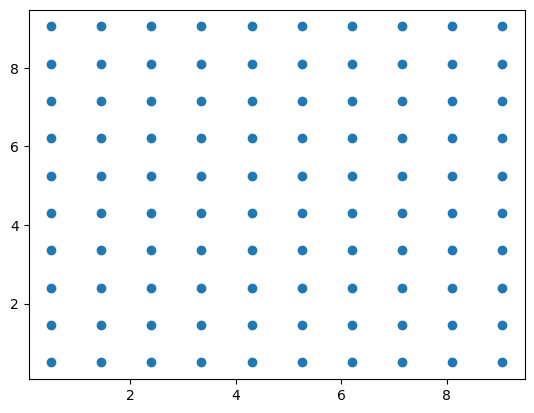

In [154]:
plt.scatter(box.particles_pos[:,:,0],box.particles_pos[:,:,1])


In [155]:
box.calculate_frog_field()
np.round(box.U_ji,1)

array([[[-0.2, -0.2],
        [ 0. , -0.2],
        [ 0. , -0.2],
        [-0. , -0.2],
        [ 0. , -0.2],
        [ 0. , -0.2],
        [-0. , -0.2],
        [ 0. , -0.2],
        [ 0. , -0.2],
        [ 0.2, -0.2]],

       [[-0.2,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [-0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [-0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0.2,  0. ]],

       [[-0.2,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [-0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [-0. ,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [ 0.2,  0. ]],

       [[-0.2, -0. ],
        [ 0. , -0. ],
        [ 0. , -0. ],
        [-0. , -0. ],
        [ 0. , -0. ],
        [ 0. , -0. ],
        [-0. , -0. ],
        [ 0. , -0. ],
        [ 0. , -0. ],
        [ 0.2, -0. ]],

       [[-0.2,  0. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ],
        [-0. ,  0. ],
        [ 0. ,  0. ],
  